<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/QE_JARVIS_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [1]:
!conda --version

conda 23.11.0


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [3]:
! conda install qe jarvis-tools -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - jarvis-tools
    - qe


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    babel-2.14.0               |     pyhd8ed1ab_0         7.3 MB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    click-8.1.7                |unix_pyh707e725_0          82 KB  conda-f

In [5]:
!which pw.x

/usr/local/bin/pw.x


In [17]:
aluminum="""FCC Al
1.0
4.06741 0.0 0.0
0.0 4.06741 0.0
0.0 0.0 4.06741
Al
4
direct
0.0 0.0 0.0
0.0 0.5 0.5
0.5 0.0 0.5
0.5 0.5 0.0
"""
# aluminum="""Al
# 1.0
# 2.4907700981617955 0 1.4380466239515413
# 0.8302566980301707 2.348320626706396 1.438046623951541
# 0 0 2.8760942620064256
# Al
# 1
# Cartesian
# 0.0 0.0 0.0
# """

In [18]:
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
atoms = Poscar.from_string(aluminum).atoms
atoms

System
1.0
4.06741 0.0 0.0
0.0 4.06741 0.0
0.0 0.0 4.06741
Al 
4 
direct
0.0 0.0 0.0 Al
0.0 0.5 0.5 Al
0.5 0.0 0.5 Al
0.5 0.5 0.0 Al

In [34]:
%%time
qe_cmd = '/usr/local/bin/pw.x'
!rm relax.json
from jarvis.tasks.qe.qe import QEjob
from jarvis.core.kpoints import Kpoints3D as Kpoints
kp=Kpoints([[5,5,5]])
# For better quality electronic structure, try k-points of [4,4,5] and also try to include DFT+U corrections
relax = {
            "control": {
                #"calculation": "'scf'",
                "calculation":  "'vc-relax'",
                "restart_mode": "'from_scratch'",
                "prefix": "'RELAX'",
                "outdir": "'./'",
                "tstress": ".true.",
                "tprnfor": ".true.",
                "disk_io": "'nowf'",
                "wf_collect": ".true.",
                "pseudo_dir": None,
                "verbosity": "'high'",
                "nstep": 100,
            },
            "system": {
                "ibrav": 0,
                "nat": None,
                "ntyp": None,
                "ecutwfc": 45,
                "ecutrho": 250,
                "q2sigma": 1,
                "ecfixed": 44.5,
                "qcutz": 800,
                "occupations": "'smearing'",
                "degauss": 0.01,
                "lda_plus_u": ".false.",
            },
            "electrons": {
                "diagonalization": "'david'",
                "mixing_mode": "'local-TF'",
                "mixing_beta": 0.3,
                "conv_thr": "1d-9",
            },
            "ions": {"ion_dynamics": "'bfgs'"},
            "cell": {"cell_dynamics": "'bfgs'", "cell_dofree": "'all'"},
        }
qejob_relax = QEjob(
    atoms=atoms,
    input_params=relax,
    output_file="relax.out",
    qe_cmd=qe_cmd,
    jobname="relax",
    kpoints=kp,
    input_file="arelax.in",
    url=None,
    psp_dir=None,
    psp_temp_name=None,
)
info = qejob_relax.runjob()

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /usr/local/bin/pw.x<arelax.in
HERE1
HERE2 /content/RELAX.save/data-file-schema.xml
CPU times: user 1.29 s, sys: 135 ms, total: 1.43 s
Wall time: 4min 54s


In [35]:
info

{'out_path': '/content/relax.out',
 'xml_path_': 'na',
 'total_energy': -362.70826458035526,
 'job_done': True,
 'xml_path': '/content/RELAX.save/data-file-schema.xml'}

In [37]:
from jarvis.io.qe.outputs import DataFileSchema
xml_dat = DataFileSchema(filename=info['xml_path'])
final_strt = xml_dat.final_structure
initial_stress = xml_dat.stress
initial_stress

array([[9.73667225e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.73667225e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.73667225e-05]])

In [39]:
final_strt

System
1.0
4.0140899678681565 0.0 0.0
0.0 4.0140899678681565 0.0
0.0 0.0 4.0140899678681565
Al 
4 
direct
0.0 0.0 0.0 Al
0.0 0.4999999959976178 0.4999999959976178 Al
0.4999999959976178 0.0 0.4999999959976178 Al
0.4999999959976178 0.4999999959976178 0.0 Al

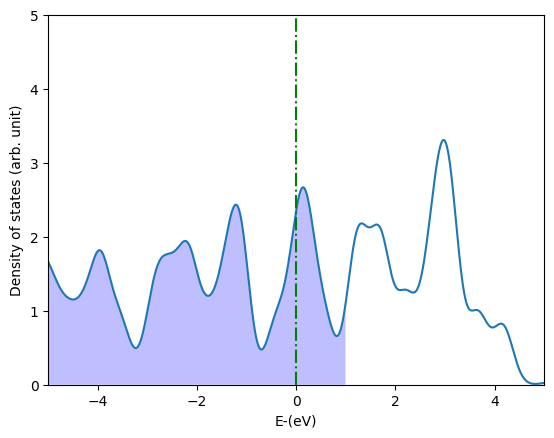

In [40]:
%matplotlib inline
energies,DOS = dos = schema.dos()
import matplotlib.pyplot as plt
plt.plot(energies,DOS)
plt.xlabel('E-(eV)')
plt.ylabel('Density of states (arb. unit)')
plt.fill_between(energies, 0, DOS, where=(energies < 1), facecolor='blue', alpha=0.25)
plt.axvline(x=0,linestyle='-.',color='green')

plt.xlim([-5,5])
plt.ylim([0,5])
plt.show()

In [41]:
strain=0.01
#strained_atoms=j_atoms.strain_atoms([[strain,0,0],[0,1,0],[0,1,0]]).ase_converter()
strained_atoms=final_strt.strain_atoms([strain,0,0])

In [42]:
strained_atoms

System
1.0
4.054230867546838 0.0 0.0
0.0 4.0140899678681565 0.0
0.0 0.0 4.0140899678681565
Al 
4 
direct
0.0 0.0 0.0 Al
0.0 0.4999999959976178 0.4999999959976178 Al
0.4950496108839602 0.0 0.4999999959976178 Al
0.4950496108839602 0.4999999959976178 0.0 Al

In [44]:
%%time
qe_cmd = '/usr/local/bin/pw.x'
!rm relax.json
from jarvis.tasks.qe.qe import QEjob
from jarvis.core.kpoints import Kpoints3D as Kpoints
kp=Kpoints([[5,5,5]])
# For better quality electronic structure, try k-points of [4,4,5] and also try to include DFT+U corrections
relax = {
            "control": {
                "calculation": "'scf'",
                #"calculation":  "'vc-relax'",
                "restart_mode": "'from_scratch'",
                "prefix": "'RELAX'",
                "outdir": "'./'",
                "tstress": ".true.",
                "tprnfor": ".true.",
                "disk_io": "'nowf'",
                "wf_collect": ".true.",
                "pseudo_dir": None,
                "verbosity": "'high'",
                "nstep": 100,
            },
            "system": {
                "ibrav": 0,
                "nat": None,
                "ntyp": None,
                "ecutwfc": 45,
                "ecutrho": 250,
                "q2sigma": 1,
                "ecfixed": 44.5,
                "qcutz": 800,
                "occupations": "'smearing'",
                "degauss": 0.01,
                "lda_plus_u": ".false.",
            },
            "electrons": {
                "diagonalization": "'david'",
                "mixing_mode": "'local-TF'",
                "mixing_beta": 0.3,
                "conv_thr": "1d-9",
            },
            "ions": {"ion_dynamics": "'bfgs'"},
            "cell": {"cell_dynamics": "'bfgs'", "cell_dofree": "'all'"},
        }
qejob_relax = QEjob(
    atoms=strained_atoms,
    input_params=relax,
    output_file="relax.out",
    qe_cmd=qe_cmd,
    jobname="relax",
    kpoints=kp,
    input_file="arelax.in",
    url=None,
    psp_dir=None,
    psp_temp_name=None,
)
info_strained = qejob_relax.runjob()

rm: cannot remove 'relax.json': No such file or directory
Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /usr/local/bin/pw.x<arelax.in
HERE1
HERE2 /content/RELAX.save/data-file-schema.xml
CPU times: user 680 ms, sys: 76.5 ms, total: 757 ms
Wall time: 2min 32s


In [45]:
from jarvis.io.qe.outputs import DataFileSchema
xml_dat_strained = DataFileSchema(filename=info_strained['xml_path'])

final_stress = xml_dat_strained.stress
final_stress

array([[ 0.00400088,  0.        ,  0.        ],
       [ 0.        , -0.00821232,  0.        ],
       [ 0.        ,  0.        , -0.00821232]])

In [47]:
160*(final_stress-initial_stress)/strain

array([[  62.45626113,    0.        ,    0.        ],
       [   0.        , -132.95500578,    0.        ],
       [   0.        ,    0.        , -132.95500578]])

In [50]:
strain=0.01
strained_atoms=final_strt.strain_atoms([[0,0,0],[0,strain,0],[0,0,0]])
strained_atoms


System
1.0
4.0140899678681565 0.0 0.0
0.0 4.054230867546838 0.0
0.0 0.0 4.0140899678681565
Al 
4 
direct
0.0 0.0 0.0 Al
0.0 0.4950496108839602 0.4999999959976178 Al
0.4999999959976178 0.0 0.4999999959976178 Al
0.4999999959976178 0.4950496108839602 0.0 Al

In [51]:
final_strt

System
1.0
4.0140899678681565 0.0 0.0
0.0 4.0140899678681565 0.0
0.0 0.0 4.0140899678681565
Al 
4 
direct
0.0 0.0 0.0 Al
0.0 0.4999999959976178 0.4999999959976178 Al
0.4999999959976178 0.0 0.4999999959976178 Al
0.4999999959976178 0.4999999959976178 0.0 Al

In [57]:
%%time
qe_cmd = '/usr/local/bin/pw.x'
!rm strained.json
from jarvis.tasks.qe.qe import QEjob
from jarvis.core.kpoints import Kpoints3D as Kpoints
kp=Kpoints([[9,9,9]])
# For better quality electronic structure, try k-points of [4,4,5] and also try to include DFT+U corrections
relax = {
            "control": {
                "calculation": "'scf'",
                #"calculation":  "'vc-relax'",
                "restart_mode": "'from_scratch'",
                "prefix": "'RELAX'",
                "outdir": "'./'",
                "tstress": ".true.",
                "tprnfor": ".true.",
                "disk_io": "'nowf'",
                "wf_collect": ".true.",
                "pseudo_dir": None,
                "verbosity": "'high'",
                "nstep": 100,
            },
            "system": {
                "ibrav": 0,
                "nat": None,
                "ntyp": None,
                "ecutwfc": 45,
                "ecutrho": 250,
                "q2sigma": 1,
                "ecfixed": 44.5,
                "qcutz": 800,
                "occupations": "'smearing'",
                "degauss": 0.01,
                "lda_plus_u": ".false.",
            },
            "electrons": {
                "diagonalization": "'david'",
                "mixing_mode": "'local-TF'",
                "mixing_beta": 0.3,
                "conv_thr": "1d-9",
            },
            "ions": {"ion_dynamics": "'bfgs'"},
            "cell": {"cell_dynamics": "'bfgs'", "cell_dofree": "'all'"},
        }
qejob_relax = QEjob(
    atoms=strained_atoms,
    input_params=relax,
    output_file="relax.out",
    qe_cmd=qe_cmd,
    jobname="strained",
    kpoints=kp,
    input_file="arelax.in",
    url=None,
    psp_dir=None,
    psp_temp_name=None,
)
info_strained = qejob_relax.runjob()

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /usr/local/bin/pw.x<arelax.in
HERE1
HERE2 /content/RELAX.save/data-file-schema.xml
CPU times: user 2.39 s, sys: 270 ms, total: 2.66 s
Wall time: 9min 15s


In [56]:
!ls -altr

total 296
drwxr-xr-x 4 root root   4096 May 28 13:23 .config
drwxr-xr-x 1 root root   4096 May 28 13:24 sample_data
drwxr-xr-x 1 root root   4096 May 30 14:23 ..
-rw-r--r-- 1 root root  22537 May 30 14:25 condacolab_install.log
-rw-r--r-- 1 root root 208399 May 30 15:22 scf_init.out
-rw-r--r-- 1 root root    927 May 30 15:58 arelax.in
drwxr-xr-x 2 root root   4096 May 30 16:01 RELAX.save
-rw-r--r-- 1 root root  35102 May 30 16:01 relax.out
-rw-r--r-- 1 root root    114 May 30 16:01 std.err
-rw-r--r-- 1 root root    163 May 30 16:01 strained.json
drwxr-xr-x 1 root root   4096 May 30 16:01 .


In [58]:
from jarvis.io.qe.outputs import DataFileSchema
xml_dat_strained = DataFileSchema(filename=info_strained['xml_path'])

final_stress = xml_dat_strained.stress
final_stress

array([[-0.00481592,  0.        ,  0.        ],
       [ 0.        , -0.00253957,  0.        ],
       [ 0.        ,  0.        , -0.00481592]])

In [59]:
160*(final_stress-initial_stress)/strain

array([[-78.61263982,   0.        ,   0.        ],
       [  0.        , -42.19091342,   0.        ],
       [  0.        ,   0.        , -78.61263982]])

In [15]:
!which pw.x

/usr/local/bin/pw.x


In [16]:
%%time
from jarvis.tasks.qe.converg import converg_kpoints
kp_len = converg_kpoints(atoms,qe_cmd='/usr/local/bin/pw.x')

Incrementing length 5
Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /usr/local/bin/pw.x<KPOINTS-5_ascf_init.in
HERE1
HERE2 /content/KPOINTS-5.save/data-file-schema.xml
Energy -87.16918841417828
Incrementing length 5
Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /usr/local/bin/pw.x<KPOINTS-10_ascf_init.in
HERE1
HERE2 /content/KPOINTS-10.save/data-file-schema.xml
Energy -90.37232259142667
Incrementing length 10
Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /usr/local/bin/pw.x<KPOINTS-15_ascf_init.in
HERE1
HERE2 /content/KPOINTS-15.save/data-file-schema.xml
Energy -90.73328731325077
Incrementing length 15
Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /usr/local/bin/pw.x<KPOINTS-20_ascf_init.in
HERE1
HERE2 /content/KPOINTS-20.save/data-file-schema.xml
Energy -90.63687778826383
Incrementing length 20
Please ci

KeyboardInterrupt: 

In [5]:
pip install mechelastic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.6/694.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 6.9 MB/s eta 0:00:00


In [1]:
!wget https://raw.githubusercontent.com/romerogroup/MechElastic/master/examples/QE_ElaStic/scf.in

--2024-05-29 13:39:02--  https://raw.githubusercontent.com/romerogroup/MechElastic/master/examples/QE_ElaStic/scf.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 690 [text/plain]
Saving to: ‘scf.in’

scf.in              100%[===================>]     690  --.-KB/s    in 0s      

2024-05-29 13:39:02 (19.8 MB/s) - ‘scf.in’ saved [690/690]



In [5]:
!pw.x < scf.in


     Program PWSCF v.7.2 starts on 29May2024 at 13:40:40 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on       2 processor cores
     Number of MPI processes:                 1
     Threads/MPI process:                     2

     MPI processes distributed on     1 nodes
     7691 MiB available memory on the printing compute node when the environment starts

     Waiting for input...
     Reading input from standard input

     Current dimensions of program PWSCF are:
     Max number o

In [2]:

from mechelastic.parsers import QE_ElaStic_Parser
from mechelastic import calculate_elastic
from mechelastic.core import ElasticProperties

calculate_elastic(
    qe_outfile="ElaStic_2nd.out", qe_infile="scf.in", crystal="cubic", code="qe_ElaStic"
)


parser = QE_ElaStic_Parser(outfile="ElaStic_2nd.out", infile="scf.in")


elastic_tensor = parser.elastic_tensor
structure = parser.structure
lattice_constant = parser.lattice_constant
crystal_type = "cubic"

elastic_properties = ElasticProperties(elastic_tensor, structure, crystal_type)

bulk_modulus_voigt = elastic_properties.bulk_modulus_voigt

  

      /\/\   ___  ___| |__   /__\ | __ _ ___| |_(_) ___
     /    \ / _ \/ __| '_ \ /_\ | |/ _` / __| __| |/ __|
    / /\/\ \  __/ (__| | | //__ | | (_| \__ \ |_| | (__
    \/    \/\___|\___|_| |_\__/ |_|\__,_|___/\__|_|\___| 

A Python library to calculate elastic properties of materials.

Version 1.2.29 created on Nov 2nd, 2021

Please cite:
- Sobhit Singh, Irais Valencia-Jaime, Olivia Pavlic, and Aldo H. Romero; Phys. Rev. B 97, 054108 (2018).
- Sobhit Singh, Logan Lang, Viviana Dovale-Farelo, Uthpala Herath, Pedram Tavadze, François-Xavier Coudert,
 and Aldo H. Romero; Computer Physics Communications 267, 108068 (2021).

Disclaimer:
Please check the authenticity of your results before publishing. 
AUTHORS of this script do not guarantee the quality and/or accuracy of results generated using this script.

------------------------------------------------------------------------------------------

This matrix was computed from qe_ElaStic


FileNotFoundError: [Errno 2] No such file or directory: 'ElaStic_2nd.out'